In [6]:
import numpy as np
import os
import pandas as pd
import sys

from matplotlib import pyplot as plt
from tqdm import tqdm

project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)
from experiments.MNIST import ExperimentFactory, ExperimentType, ExperimentADeLEn
from experiments.utils import generate_roc_df

In [2]:
from itertools import chain
def generate_roc_df(roc_list:list) -> pd.DataFrame:
    ''' 
        Create a DataFrame from a list of roc curves
        Args:
        -----
            roc_list: list
                List of N roc curves where N is the number of iterations. It is a 
                list of tuples of the form (fpr, tpr), where fpr is the false positive
                rate and tpr is the true positive rate.
        Returns:
        --------
            roc_df: pd.DataFrame
                DataFrame with multiindex
    '''
    index_names = [
        list(map(lambda x: 'It {}'.format(x), np.repeat(np.arange(len(roc_list)), 2) + 1 )),
        ['FPR', 'TPR']*len(roc_list)
    ]
        
    tuples = list(zip(*index_names))
    index = pd.MultiIndex.from_tuples(tuples)
    roc_df = pd.DataFrame(chain.from_iterable(roc_list), index=index)
    return roc_df

def generate_multi_df(data:list, index_names:list) -> pd.DataFrame:
    index_names = [
        list(map(lambda x: 'It {}'.format(x), np.repeat(np.arange(len(data)), len(index_names)) + 1 )),
        index_names*len(data)
    ]

    tuples = list(zip(*index_names))
    index = pd.MultiIndex.from_tuples(tuples)
    return pd.DataFrame(chain.from_iterable(data), index=index)

def save_result(roc:list, scores:list, metrics:np.ndarray, config:dict) -> tuple:
    '''
        Save the results of the experiment
        Args:
        -----
            roc: list
                List of roc curves
            auc: list
                List of AUC scores
            config: dict
                Configuration of the experiment

        Returns:
        --------
            roc_df: pd.DataFrame
                ROC Cuve dataFrame with multiindex, considering the iterations.
            auc_df: pd.DataFrame
                DataFrame with the AUC scores
    '''

    roc_df = generate_multi_df(roc, ['FPR', 'TPR']).T
    scores_df = generate_multi_df(scores, ['Normal', 'Anomaly']).T
    metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])
    
    roc_df.to_pickle(os.path.join(config['save_result_dir'], 'roc.pkl'))
    scores_df.to_pickle(os.path.join(config['save_result_dir'], 'sample_score.pkl'))
    metrics_df.to_csv(os.path.join(config['save_result_dir'], 'metrics.csv'))

    return roc_df, scores_df, metrics_df

# Test the pollution in dataset

In [5]:
n_iter = 2
seed = 2*np.arange(n_iter, dtype=int) + 42

# pollution_exp = [0, .05, .1, .2]
pollution_exp = [.1]
for pollution in pollution_exp:
    print(f'Exp. {pollution=}')
    iterator = tqdm(
                range(n_iter),
                leave=True,
                unit="It.",
                postfix={"AUC": "%.3f" % -1},
            )

    roc, scores = [], []
    metrics = np.empty((n_iter, 5)) # acc, prec, rec, f1, auc

    for it in iterator:
        exp = ExperimentADeLEn(known_anomalies=.1, pollution=pollution, seed=int(seed[it]))
        if it == 0:
            config = exp.config()
            exp.save_config()
        
        
        auc_score = exp.run()
        iterator.set_postfix({"AUC": "%.3f" % auc_score})

        fpr, tpr, roc_auc = exp.roc_curve()
        normal_scores, anomaly_scores = exp.score_per_label()
        acc, prec, rec, f1 = exp.classification_metrics()
        
        roc.append((fpr, tpr))   
        scores.append((normal_scores, anomaly_scores))
        metrics[it] = [acc, prec, rec, f1, roc_auc]
        
    roc_df, scores_df, metrics_df = save_result(roc, scores, metrics, config)

Exp. pollution=0.1


100%|██████████| 2/2 [01:01<00:00, 30.97s/It., AUC=0.938]


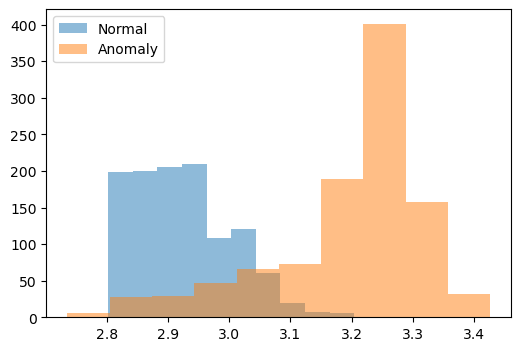

In [7]:
normal = scores_df.iloc[:, 0]
anomaly_scores = scores_df.iloc[:, 1]

plt.figure(figsize=(6, 4))
plt.hist(normal, bins=10, alpha=0.5, label='Normal')
plt.hist(anomaly_scores, bins=10, alpha=0.5, label='Anomaly')
plt.legend()
plt.show()

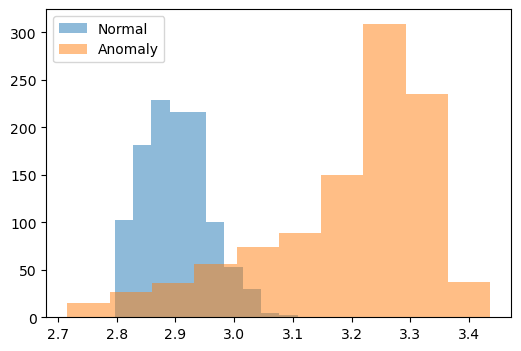

In [8]:
normal = scores_df.iloc[:, 2]
anomaly_scores = scores_df.iloc[:, 3]

plt.figure(figsize=(6, 4))
plt.hist(normal, bins=10, alpha=0.5, label='Normal')
plt.hist(anomaly_scores, bins=10, alpha=0.5, label='Anomaly')
plt.legend()
plt.show()

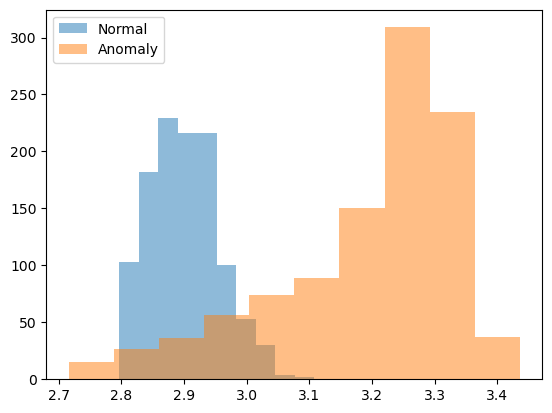

In [10]:
normal_score, anomaly_score = exp.score_per_label()
from matplotlib import pyplot as plt
plt.hist(normal_score, bins=10, alpha=0.5, label='Normal')
plt.hist(anomaly_score, bins=10, alpha=0.5, label='Anomaly')
plt.legend()

# reduce the margin of the figure
plt.show()

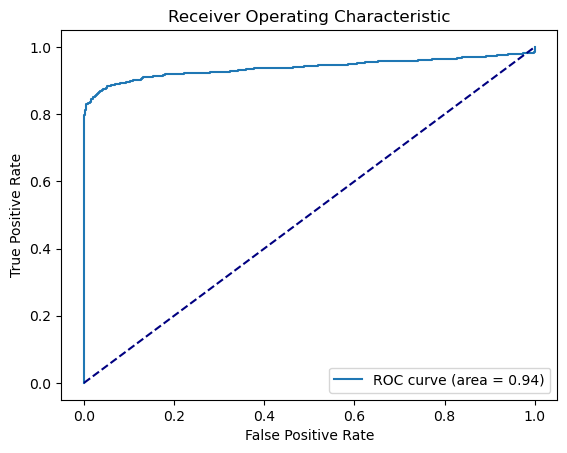

In [11]:
fpr, tpr, auc = exp.roc_curve()
# plot the roc curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# # Calcular la diferencia entre TPR y FPR para cada umbral
# differences = tpr - fpr

# # Encontrar el índice del umbral que maximiza la diferencia
# optimal_threshold_index = np.argmax(differences)

# # Obtener el umbral óptimo
# optimal_threshold = thresholds[optimal_threshold_index]

# print("Optimal threshold:", optimal_threshold)

In [ ]:
# tpr, fpr, roc_auc = experiment.to_test()

# with plt.style.context(("seaborn-colorblind")):
#     fig = plt.figure(figsize=(6, 4))
#     plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlabel('False Positive Rate', fontsize='x-large')
#     plt.ylabel('True Positive Rate', fontsize='x-large')
#     plt.legend(loc="lower right")

#     plt.tick_params(axis='both', which='major', labelsize='large')

#     plt.show()